# Denoising AutoEncoder


Antes de iniciar a execução do código faça a seguinte alteração: Menu: **Ambiente de execução -> Alterar o tipo de ambiente de execução -> GPU**

In [1]:
import numpy as np
from PIL import Image

from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Reshape, UpSampling2D, Conv2DTranspose, Dense
from keras.datasets import mnist
from keras.datasets import fashion_mnist

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from numpy.random import seed
from tensorflow.random import set_seed

**Definição de parâmetros:**

In [2]:
batchSize = 32
numberEpochs = 10
noiseFactor = 0.5

**Preparação dos dados:**






In [3]:
print("Loading MNIST images ...")
(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()

print('\tTraining set shape: ', Xtrain.shape)
print('\tTesting set shape: ', Xtest.shape)

Xtrain = Xtrain.astype('float32')
Xtest = Xtest.astype('float32')

Xtrain = Xtrain / 255
Xtest = Xtest / 255

XtrainNoise = Xtrain + noiseFactor * np.random.normal(0, 1, Xtrain.shape)
XtestNoise = Xtest + noiseFactor * np.random.normal(0, 1, Xtest.shape)

print('\tTraining noise set shape: ', XtrainNoise.shape)
print('\tTesting noise set shape: ', XtestNoise.shape)

Loading MNIST images ...
	Training set shape:  (60000, 28, 28)
	Testing set shape:  (10000, 28, 28)
	Training noise set shape:  (60000, 28, 28)
	Testing noise set shape:  (10000, 28, 28)


**Definindo o AE:**

In [4]:
print("Defining the AE ...")
input_img = Input(shape=(28, 28, 1,))

encoder = Conv2D(8, kernel_size=(3,3), strides=(2, 2), padding='same', activation='relu')(input_img)
encoder = Conv2D(8, kernel_size=(3,3), padding='same', activation='relu')(encoder)
encoder = Conv2D(8, kernel_size=(3,3), padding='same', activation='relu')(encoder)
encoder = AveragePooling2D(pool_size=(2, 2))(encoder)
encoder = Flatten(name='code')(encoder)

decoder = Reshape((7,7,8))(encoder)
decoder = UpSampling2D((2,2))(decoder)
decoder = Conv2DTranspose(8, kernel_size=(3,3), padding='same', activation='relu')(decoder)
decoder = Conv2DTranspose(8, kernel_size=(3,3), padding='same', activation='relu')(decoder)
decoder = Conv2DTranspose(1, kernel_size=(3,3), strides=(2, 2), padding='same', activation='relu')(decoder)

seed(1)
set_seed(2)

autoencoder = Model(input_img, decoder)
autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.summary()

Defining the AE ...
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         584       
_________________________________________________________________
average_pooling2d (AveragePo (None, 7, 7, 8)           0         
_________________________________________________________________
code (Flatten)               (None, 392)               0         
_________________________________________________________________
reshape (Reshape)            (None

**Treinando o AE:**

Training the Denoising AE ...
Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0425
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0382
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0377
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0374
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0372
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0371
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0370
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0369
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0369
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0369


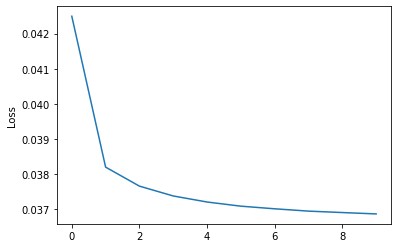

In [5]:
print("Training the Denoising AE ...")
historyDenoising = autoencoder.fit(x=XtrainNoise, y=Xtrain, batch_size=batchSize, epochs=numberEpochs, shuffle=True, verbose=1)

plt.plot(historyDenoising.history['loss'])
plt.ylabel('Loss')
plt.show()

**Verificando a capacidade de reconstrução do AE:**

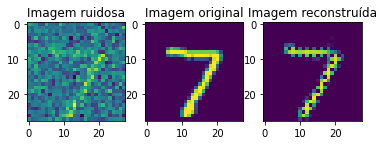

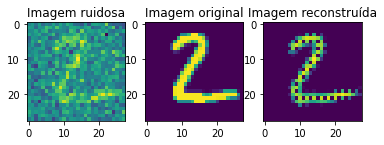

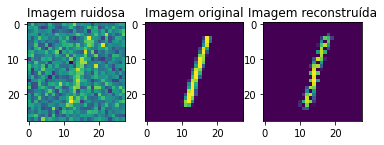

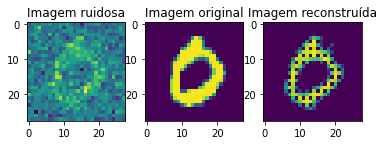

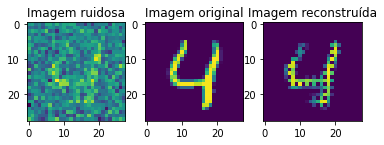

In [6]:
denoised = autoencoder.predict(XtestNoise[:5])

for i in range(0,5):
  fig, axes = plt.subplots(1, 3)
  axes[0].imshow(XtestNoise[i])
  axes[0].set_title('Imagem ruidosa')
  axes[1].imshow(Xtest[i])
  axes[1].set_title('Imagem original')
  axes[2].imshow(denoised[i][:, :, 0])
  axes[2].set_title('Imagem reconstruída')
  plt.show()

**Utilizando o AE para classificação com SVM:**

In [7]:
print("Feature extraction ...")
model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(name='code').output)

prediction = np.array(model.predict(XtrainNoise))
featuresTrain = np.reshape(prediction, (prediction.shape[0], prediction.shape[1]))

prediction = np.array(model.predict(Xtest))
featuresTest = np.reshape(prediction, (prediction.shape[0], prediction.shape[1]))

prediction = np.array(model.predict(XtestNoise))
featuresTestNoise = np.reshape(prediction, (prediction.shape[0], prediction.shape[1]))

print("Dimensionality reduction with PCA ...")
pca = PCA(n_components=32)
featuresTrain = pca.fit_transform(featuresTrain)
featuresTest = pca.transform(featuresTest)
featuresTestNoise = pca.transform(featuresTestNoise)

print("Classification with SVM ...")
svm = SVC(kernel='linear')
svm.fit(featuresTrain, np.ravel(Ytrain, order='C'))

result = svm.predict(featuresTest)
accTest = accuracy_score(result, np.ravel(Ytest, order='C'))
print("\tAccuracy Linear SVM for original set: %0.4f" % accTest)

result = svm.predict(featuresTestNoise)
accNoise = accuracy_score(result, np.ravel(Ytest, order='C'))
print("\tAccuracy Linear SVM for noisy set: %0.4f" % accNoise)



Feature extraction ...
Dimensionality reduction with PCA ...
Classification with SVM ...
	Accuracy Linear SVM for original set: 0.9350
	Accuracy Linear SVM for noisy set: 0.9065


**Reconstruindo dataset não treinado:**

Loading FASHION-MNIST images ...
	Testing set shape:  (10000, 28, 28)
	Testing noisy set shape:  (5, 28, 28)


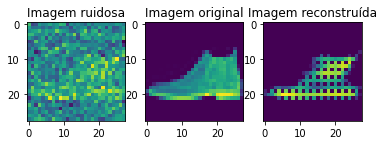

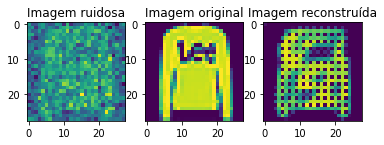

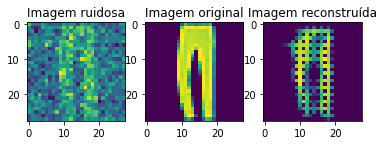

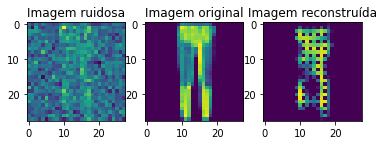

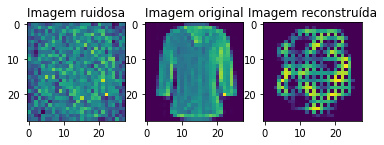

In [8]:
print("Loading FASHION-MNIST images ...")
(Xtrain, Ytrain), (Xtest, Ytest) = fashion_mnist.load_data()
print('\tTesting set shape: ', Xtest.shape)

Xtest = Xtest[:5]
Xtest = Xtest.astype('float32')
Xtest = Xtest / 255
XtestNoise = Xtest + noiseFactor * np.random.normal(0, 1, Xtest.shape)
print('\tTesting noisy set shape: ', XtestNoise.shape)

denoised = autoencoder.predict(XtestNoise)

for i in range(0,5):
  fig, axes = plt.subplots(1, 3)
  axes[0].imshow(XtestNoise[i])
  axes[0].set_title('Imagem ruidosa')
  axes[1].imshow(Xtest[i])
  axes[1].set_title('Imagem original')
  axes[2].imshow(denoised[i][:, :, 0])
  axes[2].set_title('Imagem reconstruída')
  plt.show()